In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_clusters_per_class=1,
    random_state=42
)

feature_names = [f"feature_{i}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

print("Dataset shape:", df.shape)
print("Class distribution:", df["target"].value_counts())

Dataset shape: (1000, 21)
Class distribution: target
1    503
0    497
Name: count, dtype: int64


Decision Tree Accuracy: 0.905

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        98
           1       0.88      0.94      0.91       102

    accuracy                           0.91       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.91      0.90       200



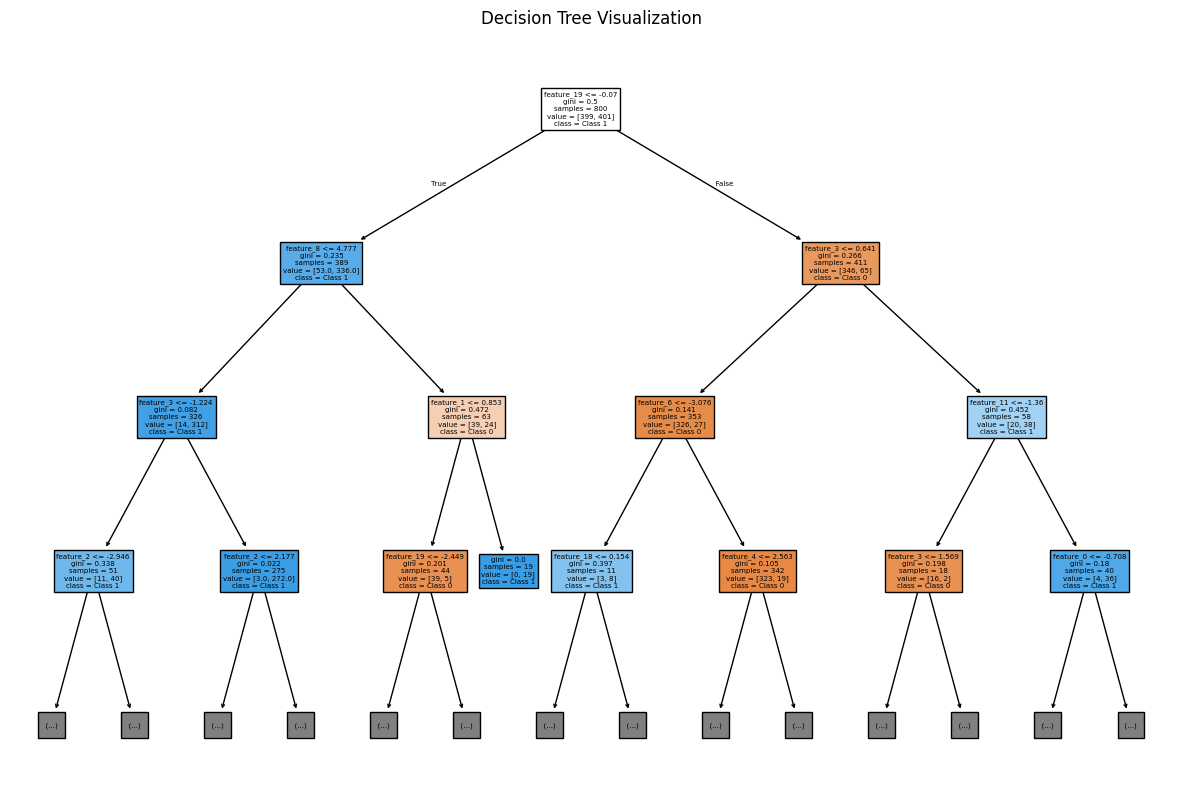

In [5]:
# Single Decision Tree
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train decision tree
dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

dt.fit(X_train, y_train)

# Predictions and evaluation
dt_pred = dt.predict(X_test)
dt_score = dt.score(X_test, y_test)

print(f"Decision Tree Accuracy: {dt_score:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_pred))

plt.figure(figsize=(15, 10))
plot_tree(dt, max_depth=3, feature_names=feature_names,
          class_names=["Class 0", "Class 1"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

Decision Tree:
  CV Score: 0.896 (+/- 0.048)
  Test Score: 0.915

Random Forest:
  CV Score: 0.966 (+/- 0.023)
  Test Score: 0.970

Gradient Boosting:
  CV Score: 0.955 (+/- 0.037)
  Test Score: 0.965



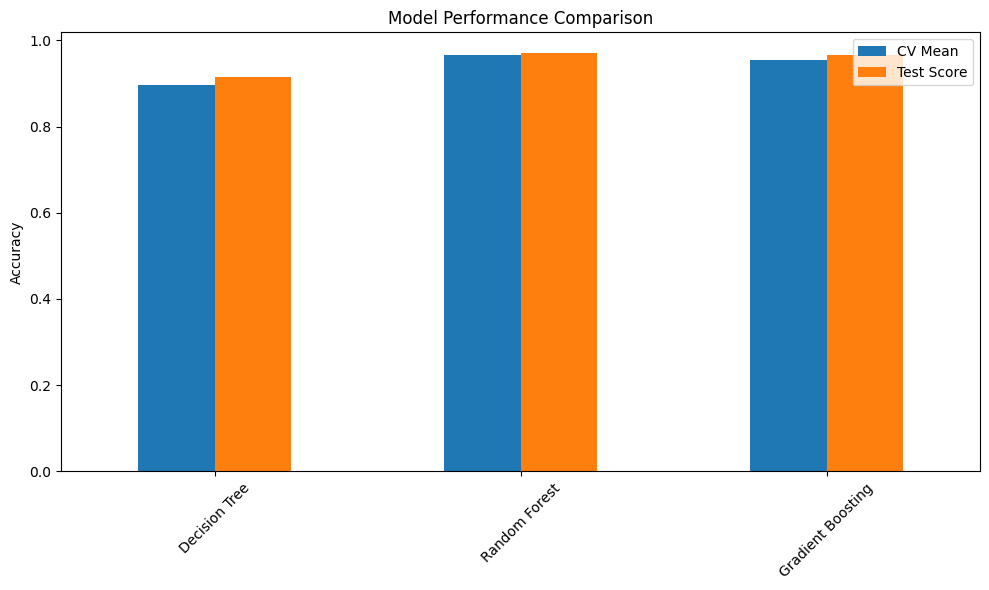

In [11]:
# Random Forest vs Gradient Boosting Comparison
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    )
}

results = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Train on full training set
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)

    results[name] = {
        "CV Mean": cv_scores.mean(),
        "CV Std": cv_scores.std(),
        "Test Score": test_score
    }

    print(f"{name}:")
    print(f"  CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"  Test Score: {test_score:.3f}\n")

scores_df = pd.DataFrame(results).T
scores_df[["CV Mean", "Test Score"]].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

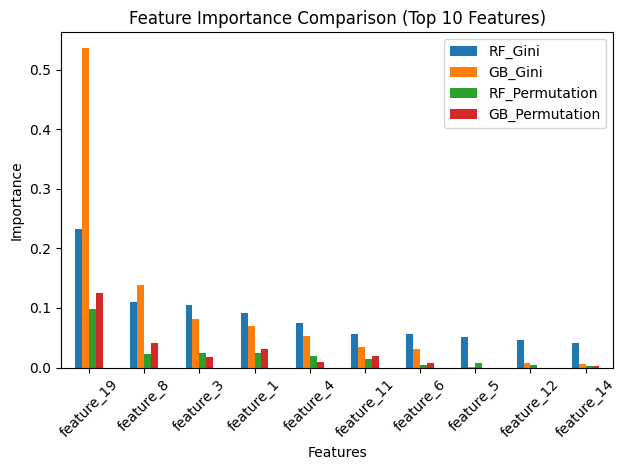

In [13]:
# Feature Importance Analysis
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Different types of importance
rf_gini_imp = rf.feature_importances_
gb_gini_imp = gb.feature_importances_

# Permutation importance
rf_perm_imp = permutation_importance(rf, X_test, y_test, random_state=42)
gb_perm_imp = permutation_importance(gb, X_test, y_test, random_state=42)

importance_df = pd.DataFrame({
    "RF_Gini": rf_gini_imp,
    "GB_Gini": gb_gini_imp,
    "RF_Permutation": rf_perm_imp.importances_mean,
    "GB_Permutation": gb_perm_imp.importances_mean
}, index=feature_names)

top_features = importance_df["RF_Gini"].nlargest(10).index
importance_subset = importance_df.loc[top_features]

plt.figure(figsize=(12, 8))
importance_subset.plot(kind="bar")
plt.title("Feature Importance Comparison (Top 10 Features)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

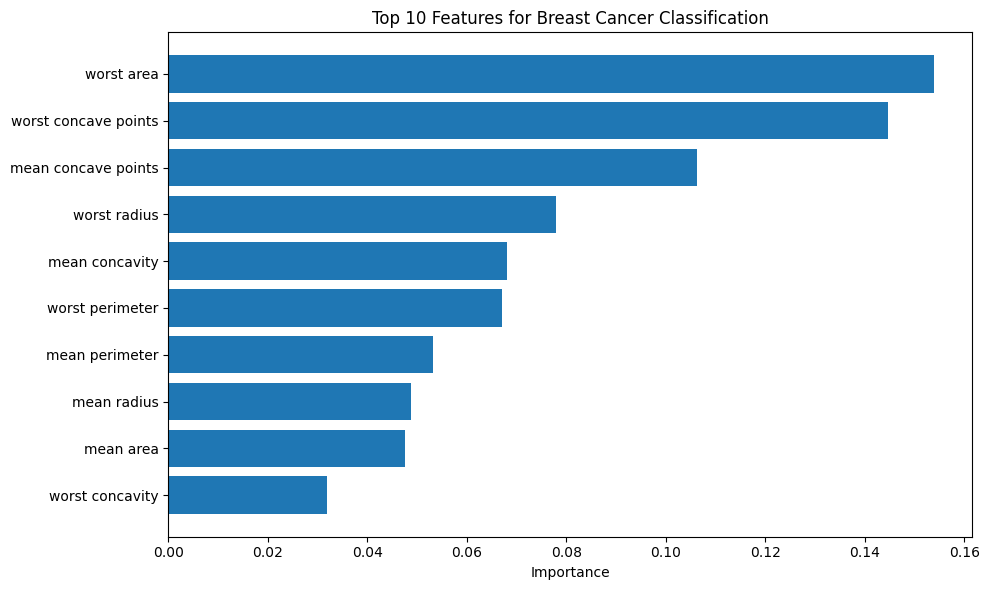

Breast Cancer RF Accuracy: 0.965


In [15]:
# Real Dataset Example (Breast Cancer)
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target
feature_names_cancer = cancer.feature_names

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42
)

# Train Random Forest
rf_cancer = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf_cancer.fit(X_train_c, y_train_c)

# Feature Importance
importance_cancer = pd.DataFrame({
    "feature": feature_names_cancer,
    "importance": rf_cancer.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
top_10 = importance_cancer.head(10)
plt.barh(range(len(top_10)), top_10["importance"])
plt.yticks(range(len(top_10)), top_10["feature"])
plt.xlabel("Importance")
plt.title("Top 10 Features for Breast Cancer Classification")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Breast Cancer RF Accuracy: {rf_cancer.score(X_test_c, y_test_c):.3f}")

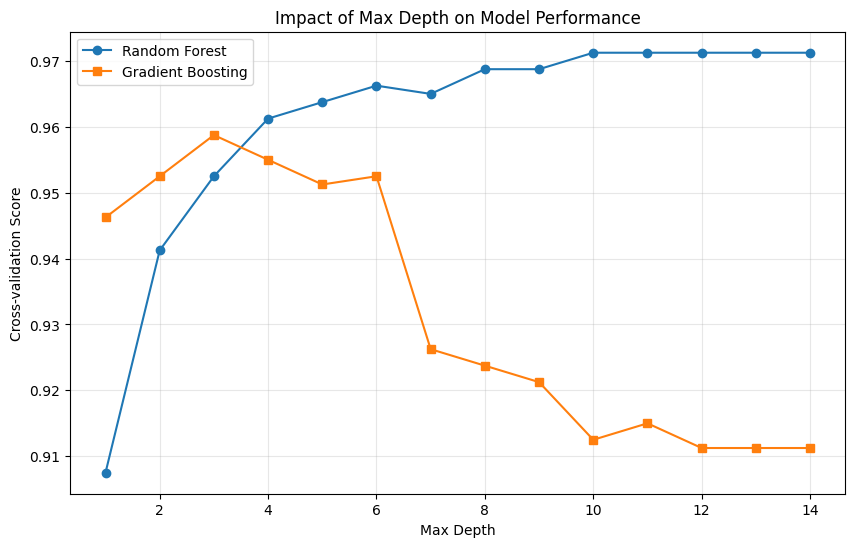

In [16]:
# Hyperparameter Impact Analysis
def analyse_hyperparameter(param_name, param_values, model_class, X, y):
    scores = []
    for value in param_values:
        model = model_class(random_state=42, **{param_name: value})
        cv_scores = cross_val_score(model, X, y, cv=5)
        scores.append(cv_scores.mean())
    return scores

depths = range(1, 15)
rf_depth_scores = analyse_hyperparameter("max_depth", depths, RandomForestClassifier, X_train, y_train)
gb_depth_scores = analyse_hyperparameter("max_depth", depths, GradientBoostingClassifier, X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(depths, rf_depth_scores, "o-", label="Random Forest")
plt.plot(depths, gb_depth_scores, "s-", label="Gradient Boosting")
plt.xlabel("Max Depth")
plt.ylabel("Cross-validation Score")
plt.title("Impact of Max Depth on Model Performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()